In [18]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from warnings import filterwarnings

# Task 3 - Regression 

## Load settings

In [2]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
filterwarnings('ignore')

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task3"
filedir = "/home/fredrik/Documents/Learning_Systems/Labs/Project/"

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [3]:
# GridSearchCV
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,1000,5000],
    },{
        'clf':[RandomForestRegressor(random_state=seed)],  
        'clf__n_estimators':[100,150,200],
        
    },{
        'clf':[MLPRegressor()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [4]:
filename = "datasets/powerTrainData.mat"

mat = loadmat(filename)
input_train = mat['powerTrainInput'].T

target_train = mat['powerTrainOutput'].reshape(len(input_train))
input_test = mat['powerTestInput'].T

## Data info

In [5]:
get_data_info(input_train, target_train)

Length of 844
X.shape: (844, 15) y.shape: (844,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[ 3.2400e+03  2.5467e+03  2.4383e+03  3.2400e+03  3.2400e+03  4.5000e+01
   3.7000e+01  4.4040e+01  4.6760e+01  2.6480e+01  1.0780e+01  3.9170e+01
   8.1400e+00  9.8200e-01  1.8800e-01]
 [ 1.8710e+03  1.7938e+03  1.7097e+03  2.0940e+03  2.0940e+03  6.1000e+01
   5.7000e+01  6.6670e+01  6.5480e+01  5.2670e+01  4.8920e+01  7.0000e+01
   7.2260e+01 -9.1200e-01 -4.0900e-01]] 
Target: [3359 1868]


## Preprocess
Normalize the dataset

In [6]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

844


## Feature reduction
Reduce dimensionality by PCA transform

In [7]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (844, 15)
transformed shape: (844, 6)
Explained variance: [0.71291343 0.08305948 0.06661705 0.04012179 0.03533515 0.02463563]


# Feature extraction

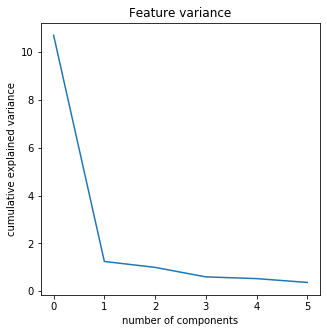

In [8]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Plot top 10 histogram over reduced features

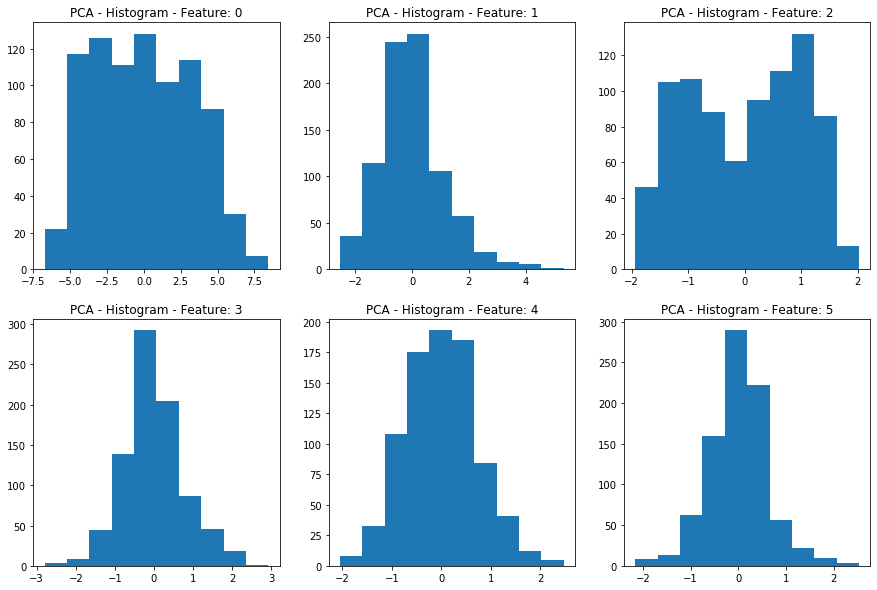

In [9]:
plot_top_features(feature_tot,pca_input, filedir=filedir, taskname=taskname)

# Feature selection
Extract top features above depending on PCA

(844, 15)


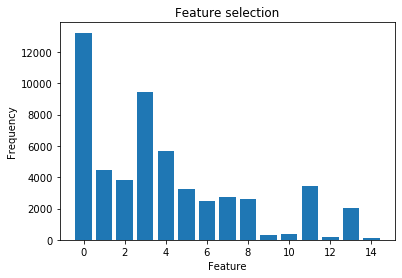

In [10]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname, feature_tot=feature_tot)

## Hyperparameter tuning

In [11]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 24.0min finished
/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Save model

In [12]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_Systems/Labs/Project/Models/task3.joblib


## Load model

In [13]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

## Get Model info

In [14]:
get_model_info(grid)

Best score: -10937.37767838326
Best params {'clf': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 20), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False), 'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__early_stopping': False, 'clf__hidden_layer_sizes': (100, 20), 'clf__max_iter': 200, 'clf__solver': 'lbfgs'}

                                                                                                                                                                                                                                                                      

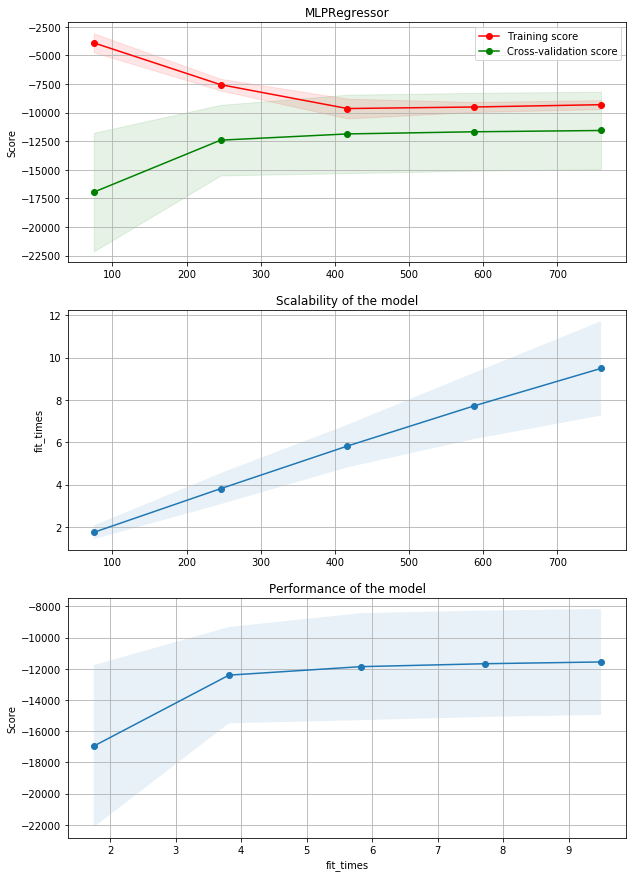

In [15]:
validate_curve(grid, input_train_fs, target_train,filedir=filedir, taskname=taskname, scoring=scoring, k=k)

/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


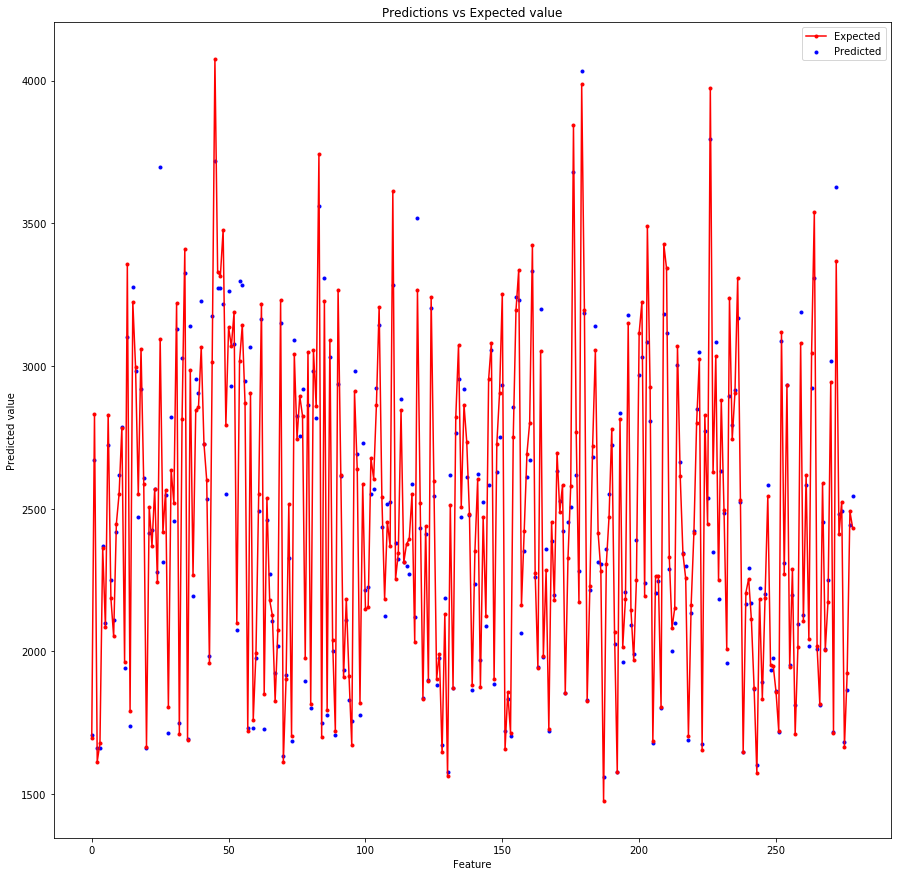

In [19]:
display_model_predict(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [17]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
print(predict)

/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
